In [85]:
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt 
import torch
from PIL import Image

## Reference

https://www.pinecone.io/learn/series/image-search/zero-shot-object-detection-clip/

## Import CLIP Model

In [221]:
from transformers import CLIPProcessor, CLIPModel
import torch

# define processor and model
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

model.to("mps")

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

## Reading input image and logo image

In [230]:
image = Image.open("/Users/abdulkarim/Downloads/70655313007-starbucks-fall-beverages.webp")
logo_image = Image.open("/Users/abdulkarim/Downloads/starbucks-logo-4-2048x1365.jpg")
#logo_image = logo_image.resize((224,224))

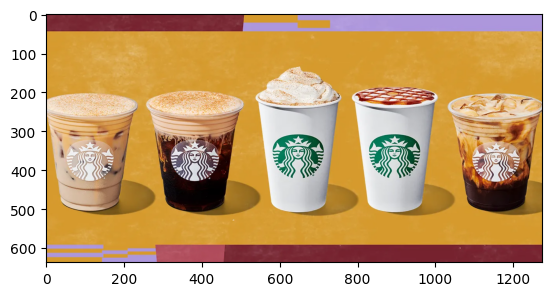

In [231]:
plt.imshow(image)

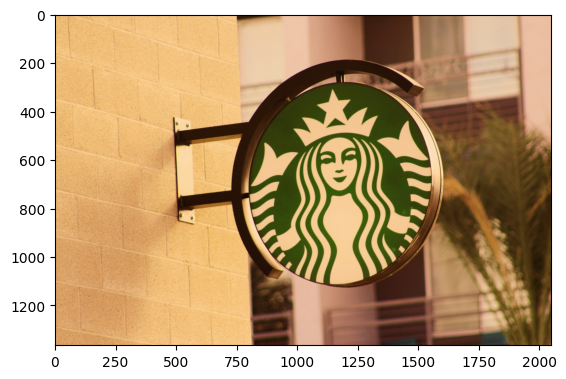

In [232]:
plt.imshow(logo_image)

In [233]:
image = transforms.functional.pil_to_tensor(image)
logo_image = transforms.functional.pil_to_tensor(logo_image)

In [234]:
image.shape, logo_image.shape

(torch.Size([4, 637, 1275]), torch.Size([3, 1365, 2048]))

In [235]:
logo_image = logo_image.unfold(0,3,3)

## Splitting input image into patches

In [236]:
# add batch dimension and shift color channels
patches = image.data.unfold(0,3,3)
patches.shape

torch.Size([1, 637, 1275, 3])

In [237]:
patch = 256

patches = patches.unfold(1, patch, patch)
patches.shape

torch.Size([1, 2, 1275, 3, 256])

In [238]:
patches = patches.unfold(2, patch, patch)
patches.shape

torch.Size([1, 2, 4, 3, 256, 256])

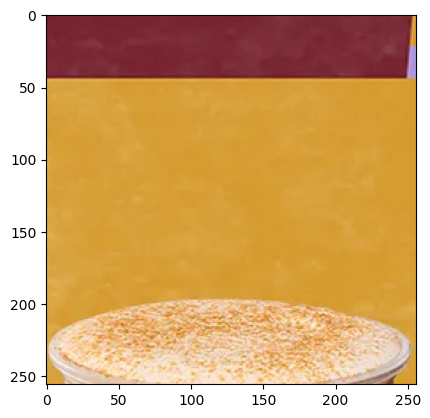

In [239]:
plt.imshow(transforms.functional.to_pil_image(patches[0][0][1]))

## Trying to find only the image embedding from CLIP model

In [240]:
inputs_logo = processor(text=["nil"], images=logo_image, return_tensors="pt", padding=True)
outputs_logo = model(**inputs_logo.to('mps'))

In [241]:
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1)

## Find cosine similarity between logo image and all patches

tensor([0.8013], device='mps:0', grad_fn=<SumBackward1>)

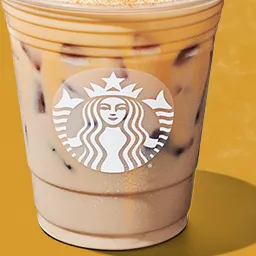

tensor([0.8175], device='mps:0', grad_fn=<SumBackward1>)

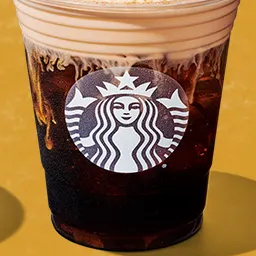

tensor([0.8511], device='mps:0', grad_fn=<SumBackward1>)

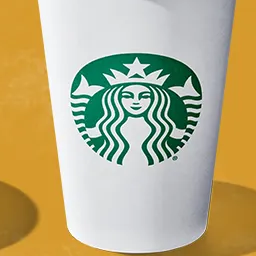

tensor([0.8258], device='mps:0', grad_fn=<SumBackward1>)

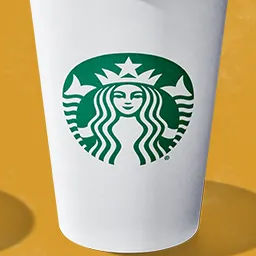

In [242]:
# find similarity for all patches
for patch_index_x in range(0,patches.shape[1]):
    for patch_index_y in range(0,patches.shape[2]):
        inputs_patch = processor(text=["nil"], images=patches[0][patch_index_x][patch_index_y], return_tensors="pt")
        outputs_patch = model(**inputs_patch.to('mps'))
        similarity = cos(outputs_logo['image_embeds'], outputs_patch['image_embeds'])
        if similarity > 0.8:
            display(similarity)
            display(transforms.functional.to_pil_image(patches[0][patch_index_x][patch_index_y]))